# J. Meyer - PGM Project - Condition Based Maintenance on Naval Propulsion Plants

## Library Imports

In [428]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import networkx as nx
import warnings
from pgmpy.estimators import HillClimbSearch, PC, TreeSearch, MaximumLikelihoodEstimator
from pgmpy.inference import BeliefPropagation, VariableElimination
from pgmpy.models import BayesianNetwork
from fitter import Fitter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Import Data

In [39]:
Columns = ["Lever Pos", "Speed", "GT Shaft Torque", "GT RPM", "GG RPM", "SP Torque", "PP Torque", 
           "HP Exit Temp", "GT In Temp", "GT Out Temp", "HP Exit Press", "GT In Press", "GT Out Press",
           "GT Exhaust Press", "TIC", "Fuel Flow", "GT Compressor Decay", "GT Turbine Decay"]
df = pd.read_csv("Data.csv",names=Columns)
df.head()

,Lever Pos,Speed,GT Shaft Torque,GT RPM,GG RPM,SP Torque,PP Torque,HP Exit Temp,GT In Temp,GT Out Temp,HP Exit Press,GT In Press,GT Out Press,GT Exhaust Press,TIC,Fuel Flow,GT Compressor Decay,GT Turbine Decay
0,1.138,3,289.964,1349.489,6677.380,7.584,7.584,464.006,288,550.563,1.096,0.998,5.947,1.019,7.137,0.082,0.95,0.975
1,2.088,6,6960.180,1376.166,6828.469,28.204,28.204,635.401,288,581.658,1.331,0.998,7.282,1.019,10.655,0.287,0.95,0.975
2,3.144,9,8379.229,1386.757,7111.811,60.358,60.358,606.002,288,587.587,1.389,0.998,7.574,1.020,13.086,0.259,0.95,0.975
3,4.161,12,14724.395,1547.465,7792.630,113.774,113.774,661.471,288,613.851,1.658,0.998,9.007,1.022,18.109,0.358,0.95,0.975
4,5.140,15,21636.432,1924.313,8494.777,175.306,175.306,731.494,288,645.642,2.078,0.998,11.197,1.026,26.373,0.522,0.95,0.975


## EDA

#### Descriptive Statistics and Initial Visualizations

In [61]:
print("Number of Data Points: %d" %len(df))

Number of Data Points: 11934


In [52]:
for col in df.columns:
    if df[col].dtype != object:
        print(str(col))
        print("mean: " + str(df[col].mean())) # pandas ignores nan by default in these calculations
        print("median: " + str(df[col].median()))
        print("mode: " + str(df[col].mode()[0]))
        print("range: (" + str(df[col].min()) + ", " + str(df[col].max()) +")\n")

Lever Pos
mean: 5.166666666666666
median: 5.14
mode: 1.138
range: (1.138, 9.3)

Speed
mean: 15.0
median: 15.0
mode: 3
range: (3, 27)

GT Shaft Torque
mean: 27247.498685185186
median: 21630.659
mode: 50992.96
range: (253.547, 72784.872)

GT RPM
mean: 2136.2892562426678
median: 1924.326
mode: 2678.078
range: (1307.675, 3560.741)

GG RPM
mean: 8200.947312384782
median: 8482.0815
mode: 6589.002
range: (6589.002, 9797.103)

SP Torque
mean: 227.33576822523884
median: 175.268
mode: 60.337
range: (5.304, 645.249)

PP Torque
mean: 227.33576822523884
median: 175.268
mode: 60.337
range: (5.304, 645.249)

HP Exit Temp
mean: 735.4954461203284
median: 706.038
mode: 574.611
range: (442.364, 1115.797)

GT In Temp
mean: 288.0
median: 288.0
mode: 288
range: (288, 288)

GT Out Temp
mean: 646.2153310708899
median: 637.1415
mode: 559.331
range: (540.442, 789.094)

HP Exit Press
mean: 2.35296279537456
median: 2.083
mode: 1.391
range: (1.093, 4.56)

GT In Press
mean: 0.9979999999999998
median: 0.998
mode: 0.

In [54]:
print(df.describe())

          Lever Pos         Speed  GT Shaft Torque        GT RPM  \
count  11934.000000  11934.000000     11934.000000  11934.000000   
mean       5.166667     15.000000     27247.498685   2136.289256   
std        2.626388      7.746291     22148.613155    774.083881   
min        1.138000      3.000000       253.547000   1307.675000   
25%        3.144000      9.000000      8375.883750   1386.758000   
50%        5.140000     15.000000     21630.659000   1924.326000   
75%        7.148000     21.000000     39001.426750   2678.079000   
max        9.300000     27.000000     72784.872000   3560.741000   

             GG RPM     SP Torque     PP Torque  HP Exit Temp  GT In Temp  \
count  11934.000000  11934.000000  11934.000000  11934.000000     11934.0   
mean    8200.947312    227.335768    227.335768    735.495446       288.0   
std     1091.315507    200.495889    200.495889    173.680552         0.0   
min     6589.002000      5.304000      5.304000    442.364000       288.0   
25

#### Histograms of all variables

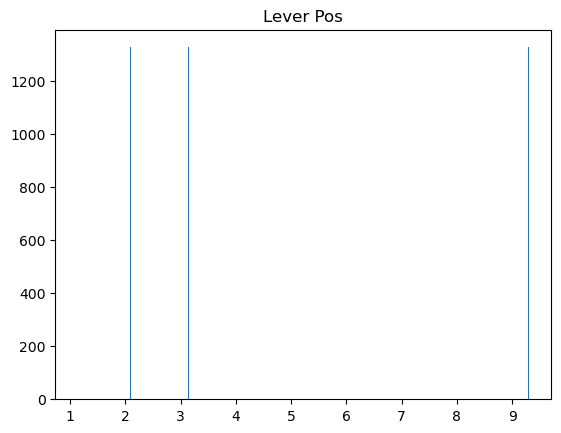

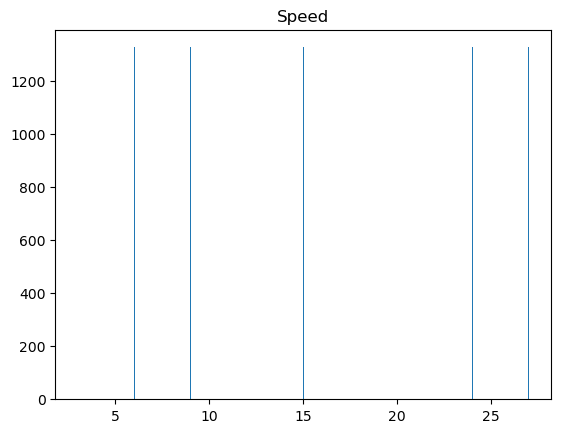

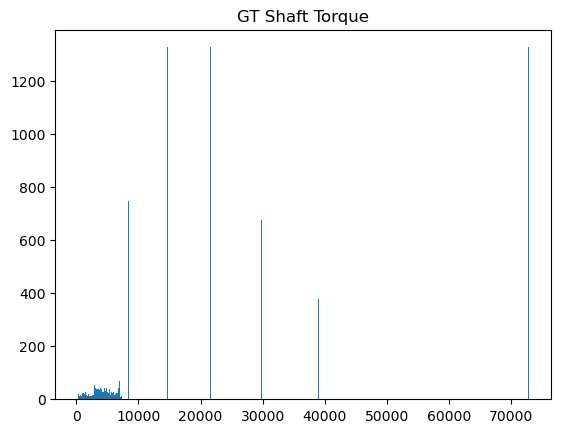

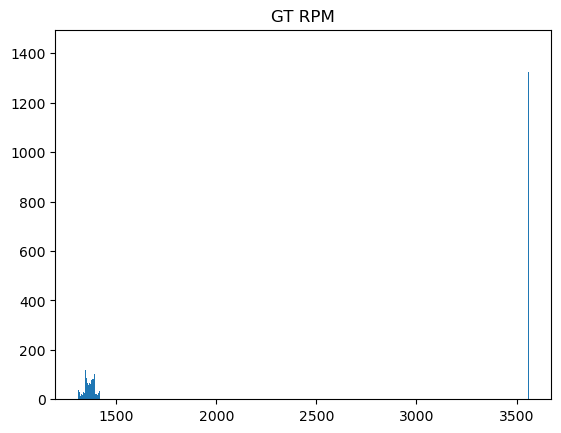

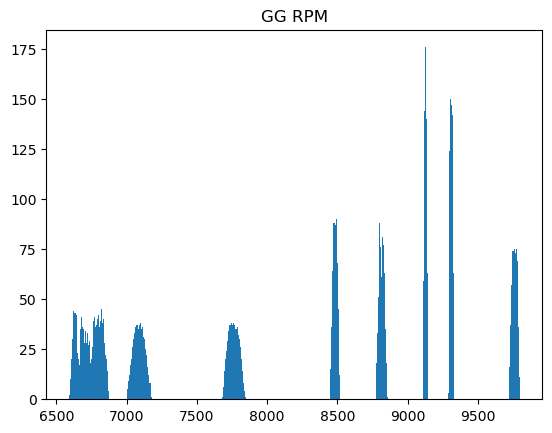

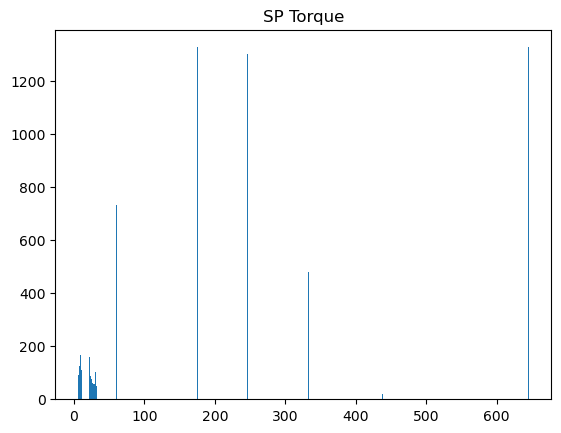

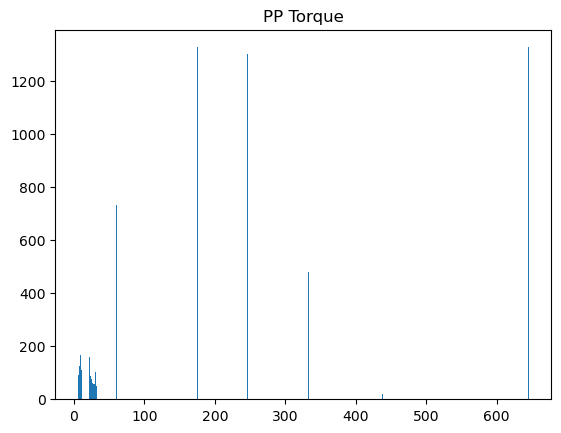

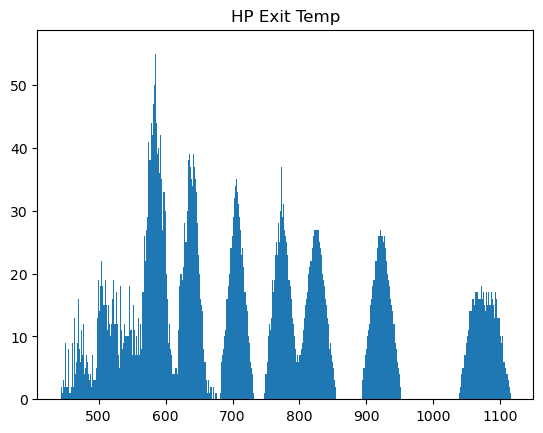

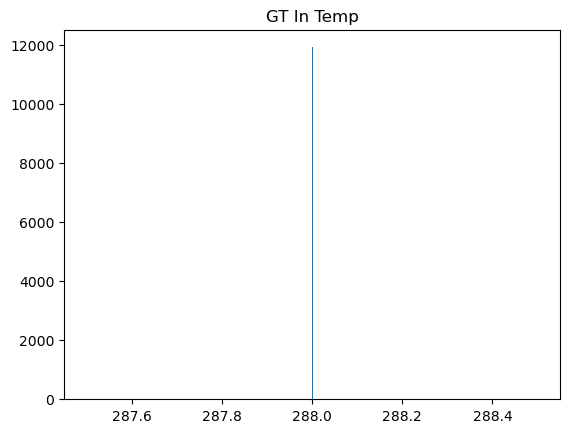

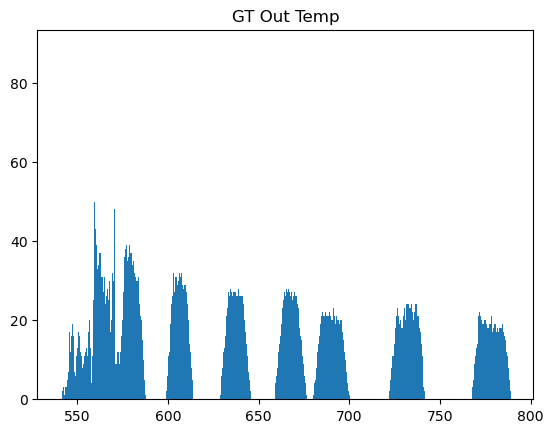

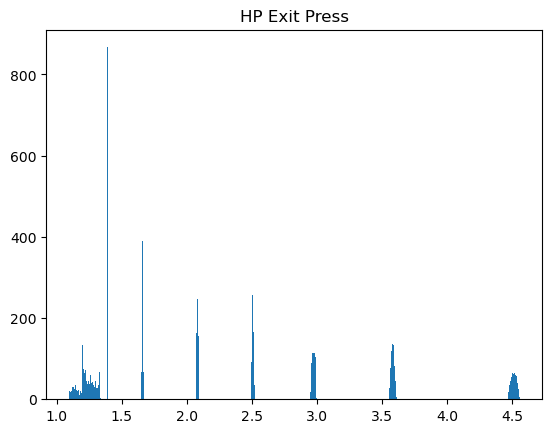

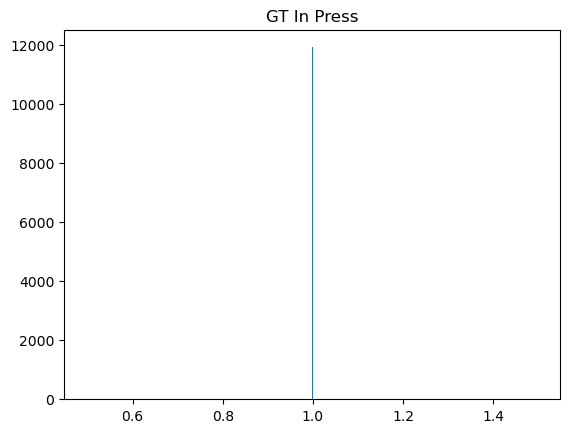

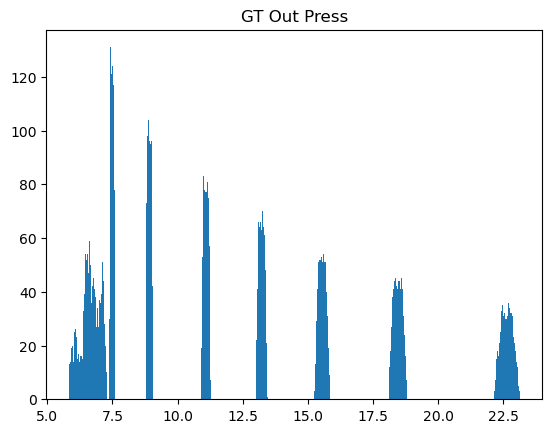

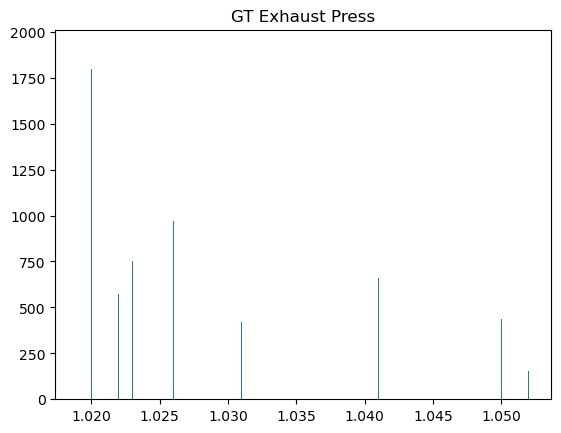

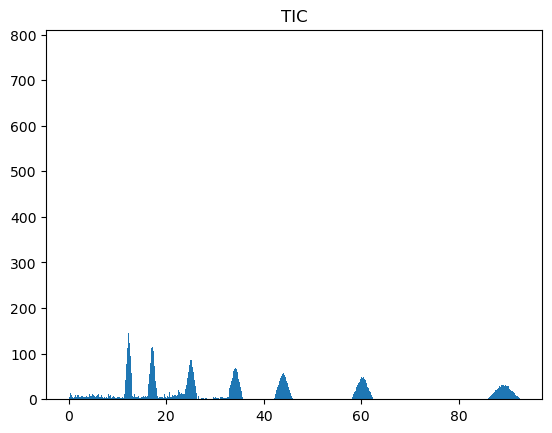

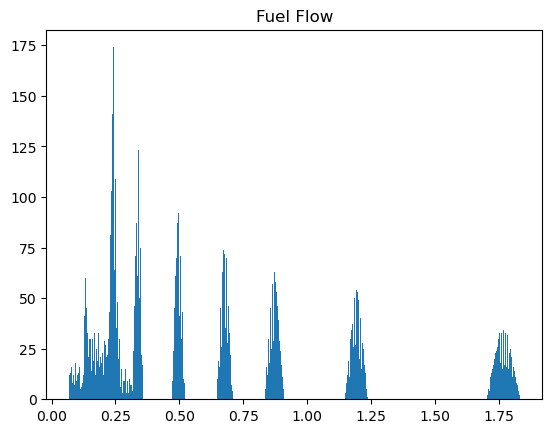

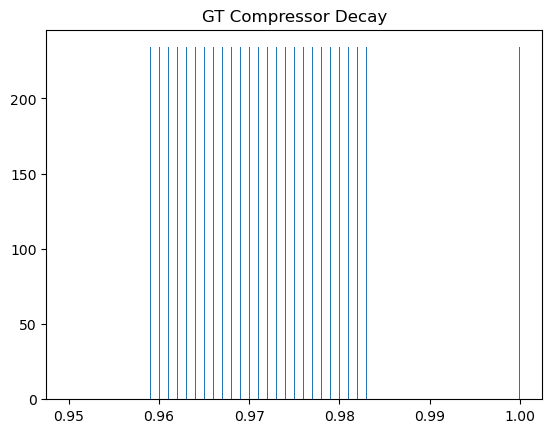

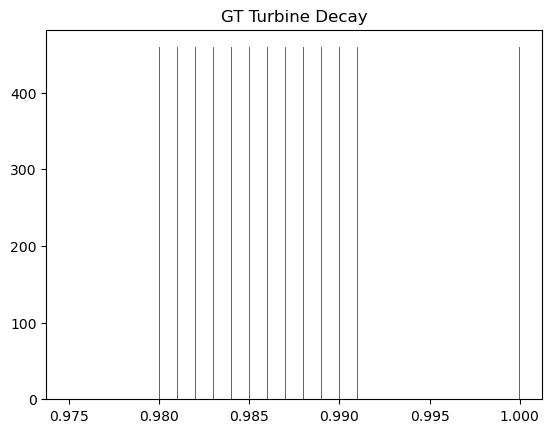

In [69]:
for col in df.columns:
    plt.figure()
    plt.hist(df[col],bins=1000)
    plt.title(col)
    plt.show()

#### Scale, Fit marginals, and Evaluate Dependencies

In [75]:
scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
df_norm.head()
print(df_norm.describe())

          Lever Pos         Speed  GT Shaft Torque        GT RPM  \
count  11934.000000  11934.000000     11934.000000  11934.000000   
mean       0.493588      0.500000         0.372170      0.367772   
std        0.321782      0.322762         0.305366      0.343569   
min        0.000000      0.000000         0.000000      0.000000   
25%        0.245773      0.250000         0.111984      0.035100   
50%        0.490321      0.500000         0.294729      0.273694   
75%        0.736339      0.750000         0.534223      0.608240   
max        1.000000      1.000000         1.000000      1.000000   

             GG RPM     SP Torque     PP Torque  HP Exit Temp  GT In Temp  \
count  11934.000000  11934.000000  11934.000000  11934.000000     11934.0   
mean       0.502461      0.346954      0.346954      0.435279         0.0   
std        0.340175      0.313302      0.313302      0.257903         0.0   
min        0.000000      0.000000      0.000000      0.000000         0.0   
25

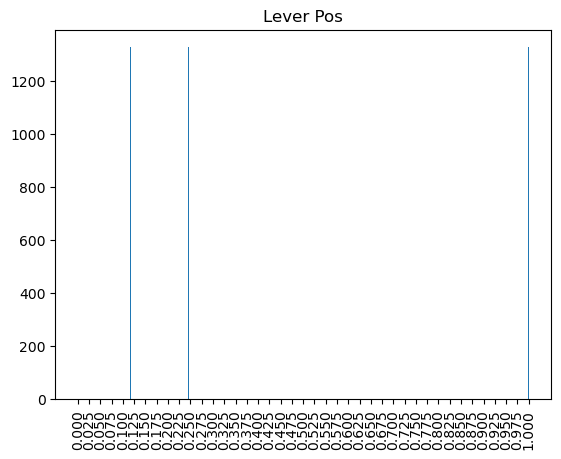

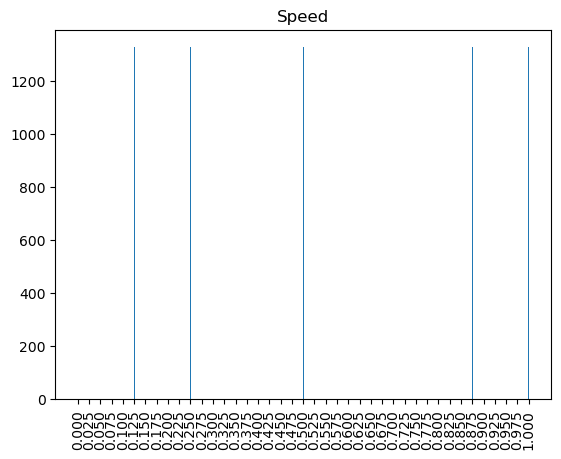

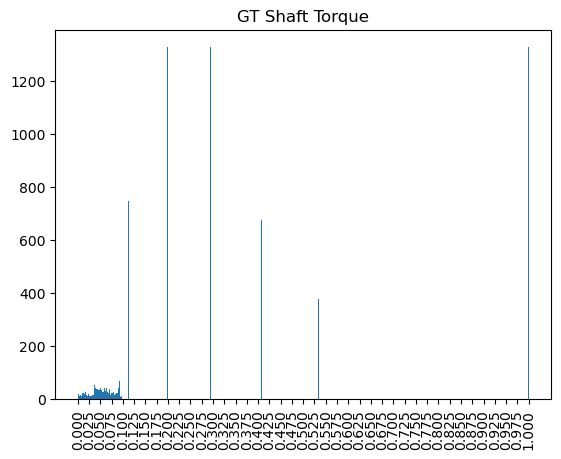

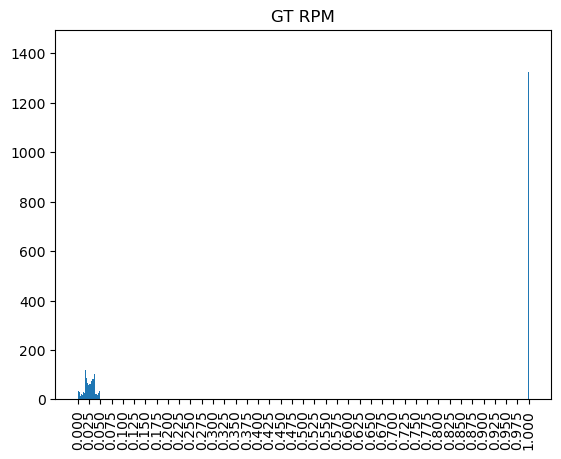

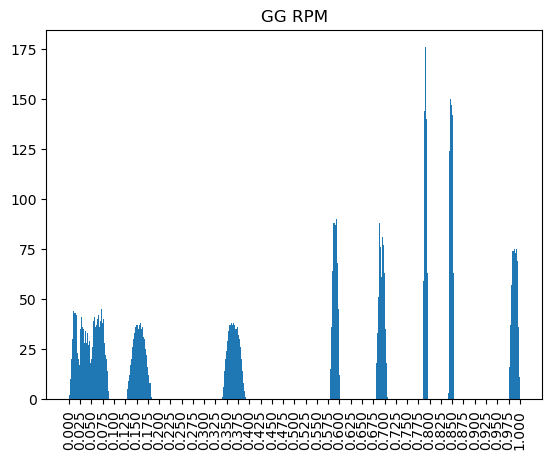

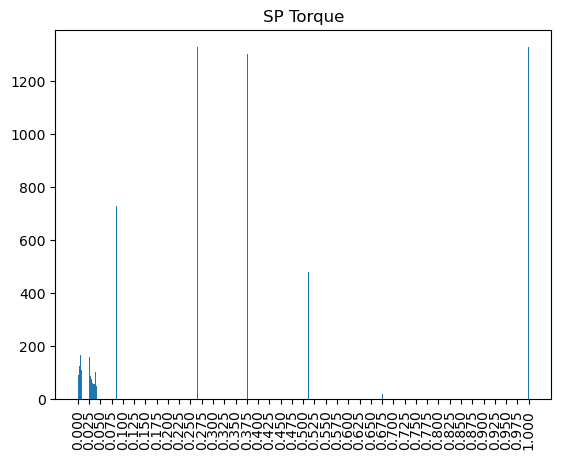

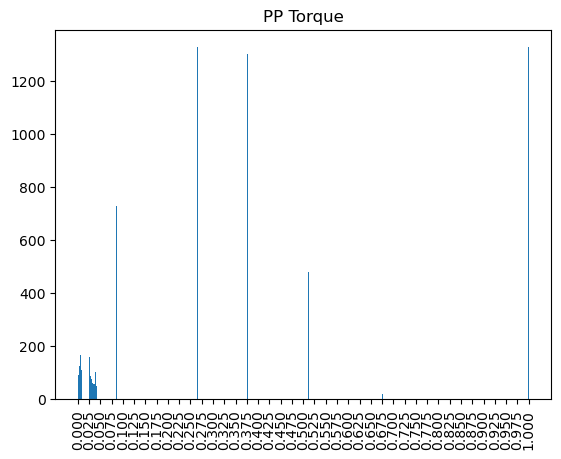

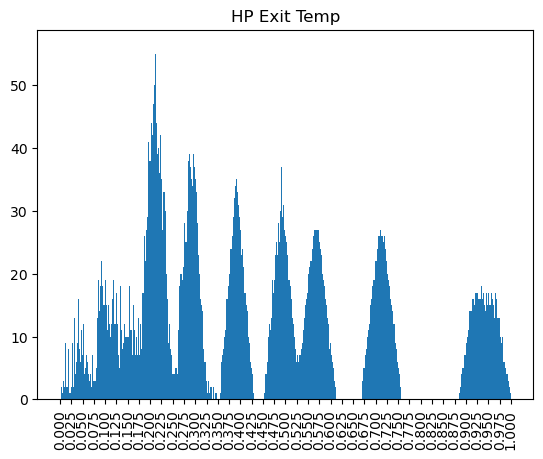

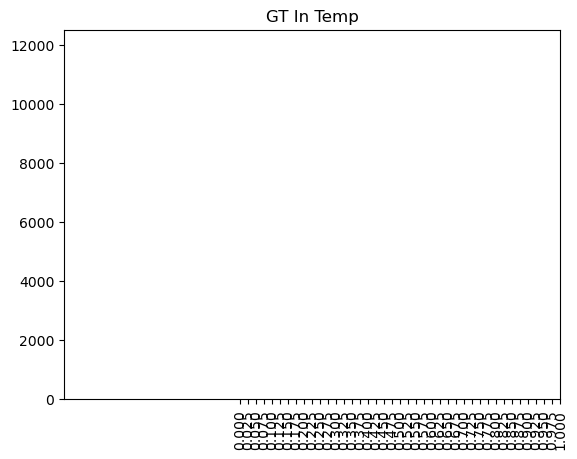

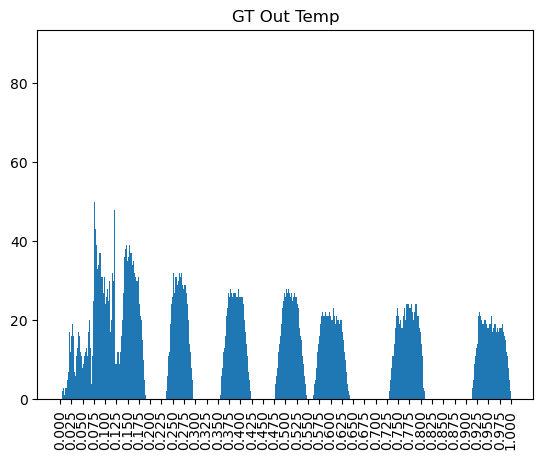

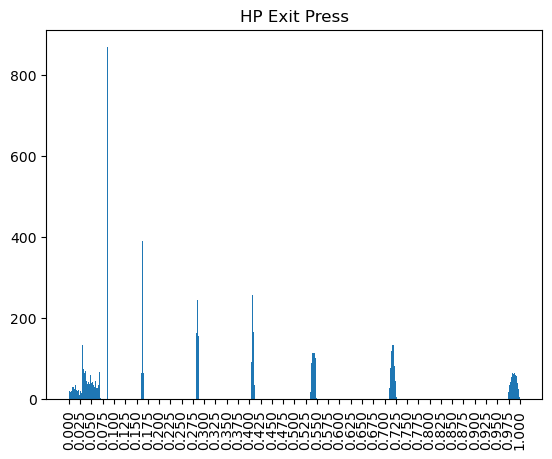

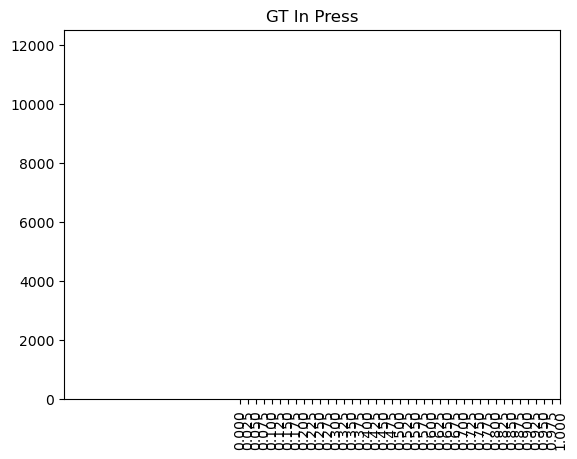

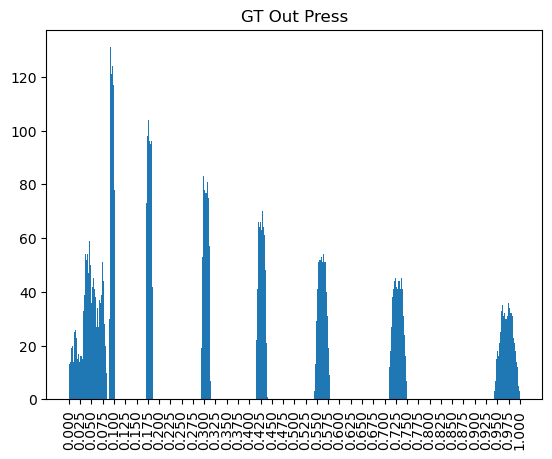

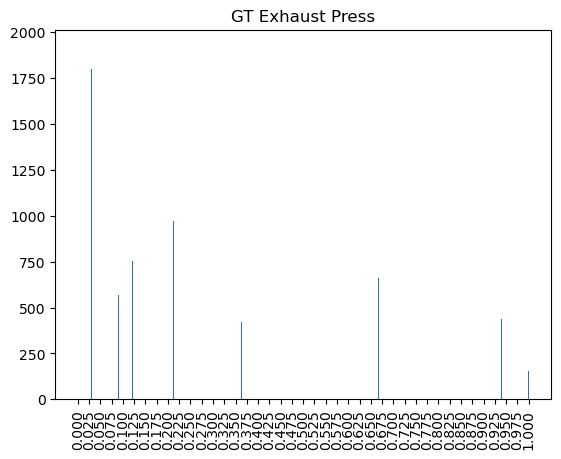

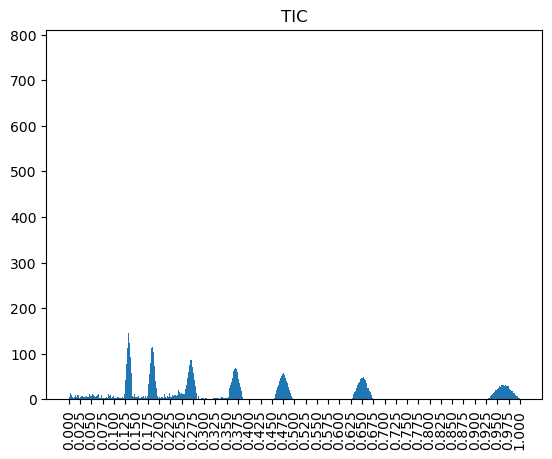

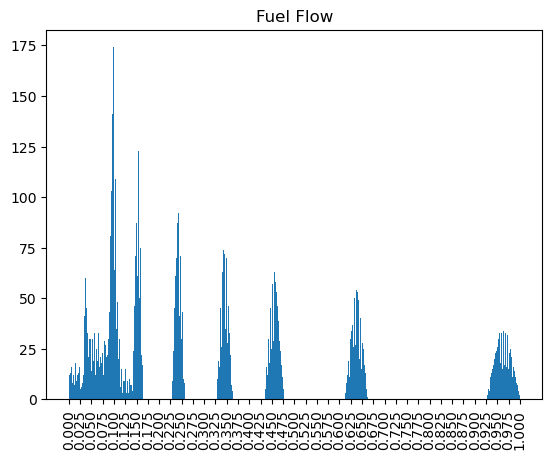

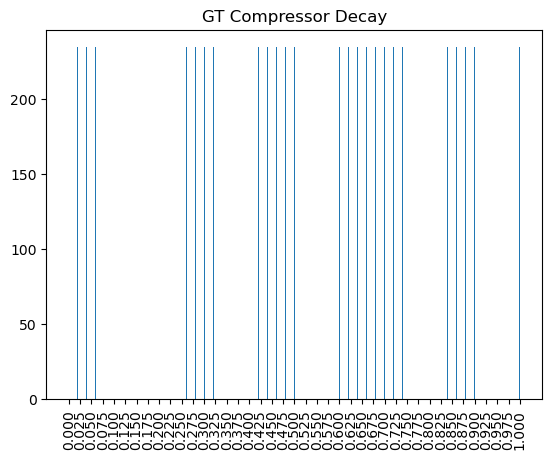

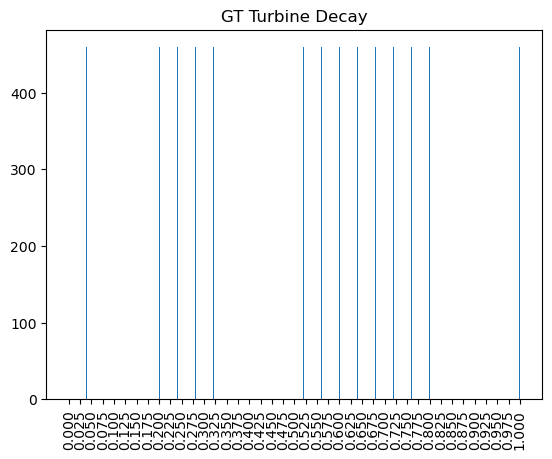

In [93]:
for col in df_norm.columns:
    plt.figure()
    plt.hist(df_norm[col],bins=1000)
    plt.xticks([0.025*i for i in range(41)],rotation=90)
    plt.title(col)
    plt.show()

In [89]:
print(df_norm.nunique())

Lever Pos                  9
Speed                      9
GT Shaft Torque        11430
GT RPM                  3888
GG RPM                 11834
SP Torque               4286
PP Torque               4286
HP Exit Temp           11772
GT In Temp                 1
GT Out Temp            11506
HP Exit Press            524
GT In Press                1
GT Out Press            4209
GT Exhaust Press          19
TIC                     8496
Fuel Flow                696
GT Compressor Decay       51
GT Turbine Decay          26
dtype: int64


Lever Pos
           sumsquare_error         aic         bic  kl_div  ks_statistic  \
arcsine         972.980731   68.863886   83.638179     inf      0.202768   
johnsonsb       976.352597  236.975041  266.523628     inf      0.515466   
burr            991.838772  110.874239  140.422826     inf      0.329422   
genpareto       995.056584   17.436561   39.598001     inf      0.151364   
exponpow        997.622120   77.883332  100.044772     inf      0.224588   

               ks_pvalue  
arcsine     0.000000e+00  
johnsonsb   0.000000e+00  
burr        0.000000e+00  
genpareto  3.522421e-239  
exponpow    0.000000e+00  
Speed
            sumsquare_error         aic         bic  kl_div  ks_statistic  \
johnsonsb        970.362202  264.218289  293.766876     inf      0.415333   
arcsine          972.148038   68.863886   83.638180     inf      0.202768   
exponweib        985.889672   63.154623   92.703210     inf      0.235036   
genpareto        988.152392   20.511086   42.672526     i

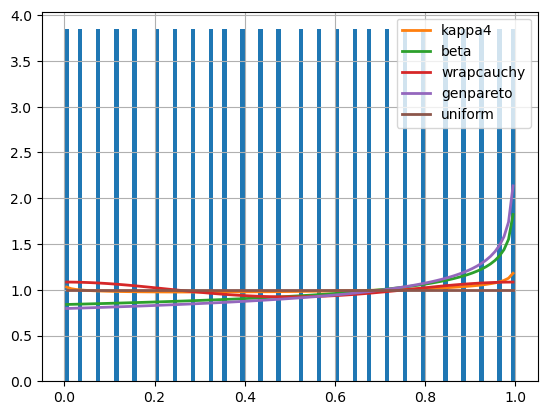

In [113]:
fits = []
for col in df_norm.columns:
    f = Fitter(df_norm[col])
    f.fit()
    fits.append(f)
    print(col)
    print(f.summary())

In [121]:
print(df_norm.cov())

                        Lever Pos     Speed  GT Shaft Torque    GT RPM  \
Lever Pos            1.035439e-01  0.103850         0.094432  0.106363   
Speed                1.038504e-01  0.104175         0.094445  0.106501   
GT Shaft Torque      9.443175e-02  0.094445         0.093248  0.103836   
GT RPM               1.063633e-01  0.106501         0.103836  0.118040   
GG RPM               1.079317e-01  0.108327         0.096917  0.110216   
SP Torque            9.670586e-02  0.096710         0.095593  0.106416   
PP Torque            9.670586e-02  0.096710         0.095593  0.106416   
HP Exit Temp         7.977222e-02  0.079815         0.078056  0.086803   
GT In Temp           0.000000e+00  0.000000         0.000000  0.000000   
GT Out Temp          9.242779e-02  0.092560         0.088380  0.099341   
HP Exit Press        9.696133e-02  0.097010         0.095439  0.106971   
GT In Press          0.000000e+00  0.000000         0.000000  0.000000   
GT Out Press         9.614419e-02  0.0

In [193]:
Rows = list(df_norm.cov().columns)
for col in df_norm.cov().columns:
    Rows.remove(col)
    for row in Rows:
        if df_norm.cov()[col][row] <= 1*10**(-30):
            print("%s and %s are nearly independent" % (col,row))

Lever Pos and GT In Temp are nearly independent
Lever Pos and GT In Press are nearly independent
Speed and GT In Temp are nearly independent
Speed and GT In Press are nearly independent
Speed and GT Compressor Decay are nearly independent
Speed and GT Turbine Decay are nearly independent
GT Shaft Torque and GT In Temp are nearly independent
GT Shaft Torque and GT In Press are nearly independent
GT RPM and GT In Temp are nearly independent
GT RPM and GT In Press are nearly independent
GT RPM and GT Turbine Decay are nearly independent
GG RPM and GT In Temp are nearly independent
GG RPM and GT In Press are nearly independent
GG RPM and GT Compressor Decay are nearly independent
SP Torque and GT In Temp are nearly independent
SP Torque and GT In Press are nearly independent
PP Torque and GT In Temp are nearly independent
PP Torque and GT In Press are nearly independent
HP Exit Temp and GT In Temp are nearly independent
HP Exit Temp and GT In Press are nearly independent
HP Exit Temp and G

In [195]:
Rows = list(df_norm.cov().columns)
for col in df_norm.cov().columns:
    Rows.remove(col)
    for row in Rows:
        if df_norm.cov()[col][row] >= 0.1:
            print("%s and %s are notably dependent" % (col,row))

Lever Pos and Speed are notably dependent
Lever Pos and GT RPM are notably dependent
Lever Pos and GG RPM are notably dependent
Speed and GT RPM are notably dependent
Speed and GG RPM are notably dependent
GT Shaft Torque and GT RPM are notably dependent
GT RPM and GG RPM are notably dependent
GT RPM and SP Torque are notably dependent
GT RPM and PP Torque are notably dependent
GT RPM and HP Exit Press are notably dependent
GT RPM and GT Out Press are notably dependent
GT RPM and GT Exhaust Press are notably dependent


#### Discretize

In [141]:
df_discrete = df_norm.copy()

bin_cuts = {"GT Shaft Torque":([-0.1,0.025,0.05,0.075,0.1,0.15,0.25,0.35,0.45,0.55,1.1],["1","2","3","4","5","6","7","8","9","10"]),
            "GT RPM":([-0.1,0.5,1.1],["Low","High"]), 
            "GG RPM":([-0.1,0.025,0.055,0.1,0.25,0.45,0.65,0.75,0.825,0.925,1.1],["1","2","3","4","5","6","7","8","9","10"]),
            "SP Torque":([-0.1,0.025,0.05,0.15,0.3,0.45,0.6,0.75,1.1],["1","2","3","4","5","6","7","8"]),
            "PP Torque":([-0.1,0.025,0.05,0.15,0.3,0.45,0.6,0.75,1.1],["1","2","3","4","5","6","7","8"]),
            "HP Exit Temp":([-0.1,0.075,0.15,0.25,0.35,0.45,0.525,0.625,0.825,1.1],["1","2","3","4","5","6","7","8","9"]),
            "GT Out Temp":([-0.1,0.075,0.125,0.2,0.325,0.45,0.55,0.7,0.85,1.1],["1","2","3","4","5","6","7","8","9"]),
            "HP Exit Press":([-0.1,0.025,0.075,0.125,0.25,0.35,0.5,0.625,0.85,1.1],["1","2","3","4","5","6","7","8","9"]),
            "GT Out Press":([-0.1,0.025,0.06,0.1,0.15,0.25,0.375,0.5,0.65,0.85,1.1],["1","2","3","4","5","6","7","8","9","10"]),
            "TIC":([-0.1,0.1,0.15,0.225,0.325,0.425,0.44,0.75,1.1],["1","2","3","4","5","6","7","8"]),
            "Fuel Flow":([-0.1,0.075,0.125,0.2,0.3,0.4,0.55,0.75,1.1],["1","2","3","4","5","6","7","8"]),
            "GT Compressor Decay":([-0.1,0.24,0.76,1.1],["Low","Normal","High"]),
            "GT Turbine Decay":([-0.1,0.24,0.76,1.1],["Low","Normal","High"])
           }
NoChange = ["Lever Pos", "Speed", "GT In Temp", "GT In Press", "GT Exhaust Press"]

for col in bin_cuts.keys():
    df_discrete[col] = pd.cut(df_norm[col],bins=bin_cuts[col][0],labels=bin_cuts[col][1])
df_discrete.head()

,Lever Pos,Speed,GT Shaft Torque,GT RPM,GG RPM,SP Torque,PP Torque,HP Exit Temp,GT In Temp,GT Out Temp,HP Exit Press,GT In Press,GT Out Press,GT Exhaust Press,TIC,Fuel Flow,GT Compressor Decay,GT Turbine Decay
0,0.000000,0.000,1,Low,2,1,1,1,0.0,1,1,0.0,1,0.000000,1,1,Low,Low
1,0.116393,0.125,4,Low,3,2,2,4,0.0,3,2,0.0,3,0.000000,2,2,Low,Low
2,0.245773,0.250,5,Low,4,3,3,3,0.0,3,3,0.0,4,0.030303,2,2,Low,Low
3,0.370375,0.375,6,Low,5,4,4,4,0.0,4,4,0.0,5,0.090909,3,3,Low,Low
4,0.490321,0.500,7,Low,6,4,4,5,0.0,5,5,0.0,6,0.212121,4,4,Low,Low


In [148]:
for col in df_discrete.columns:
    print(df_discrete[col].value_counts())
    print()

Lever Pos
0.000000    1326
0.116393    1326
0.245773    1326
0.370375    1326
0.490321    1326
0.617128    1326
0.736339    1326
0.865964    1326
1.000000    1326
Name: count, dtype: int64

Speed
0.000    1326
0.125    1326
0.250    1326
0.375    1326
0.500    1326
0.625    1326
0.750    1326
0.875    1326
1.000    1326
Name: count, dtype: int64

GT Shaft Torque
10    2652
5     1326
6     1326
7     1326
8     1326
9     1326
2      835
3      751
4      592
1      474
Name: count, dtype: int64

GT RPM
Low     7956
High    3978
Name: count, dtype: int64

GG RPM
4     1326
5     1326
6     1326
7     1326
8     1326
9     1326
10    1326
3     1084
2      919
1      649
Name: count, dtype: int64

SP Torque
4    2652
1    1326
2    1326
3    1326
5    1326
6    1326
7    1326
8    1326
Name: count, dtype: int64

PP Torque
4    2652
1    1326
2    1326
3    1326
5    1326
6    1326
7    1326
8    1326
Name: count, dtype: int64

HP Exit Temp
3    2372
4    1609
7    1350
5    1326
8    13

#### Summary and Comments

The data was generated via a simulation with set parameters, as such we see some interesting distributions of values. Because of this, the majority of the variables have multiple peaks and are not well-defined, marginally, by a distribution. We chose to normalize the data for ease and discretize the variables based on the various peaks within the data. This yields relatively even amounts of observations at each level of operation, eases future computation, and is still easily interpretable. It is also likely that this helps smooth some natural variability in the data to create more meaningful results (for example the RPMs are measured exactly to the single digit but realistically the operational engineers are looking only at the 10s or 100s place for differences). We will use the discretized data set moving forward noting that the specific values are normalized for all variables and for the specifically changed variables, 1 corresponds to the lower values and increasing to a max of 8-10 depending on the specific variable. Further we use the quantiles to define a high low or normal value for the each of the Decay variables which are our relevant classification points for inference. The data was generated with a uniform distribution on these decay states so this is a reasonable choice. There is additionally a notable amount of independencies that we will hopefully note in the learned structure.

## Model Development

#### Split Data

In [155]:
train_df, test_df = train_test_split(df_discrete, test_size=0.25, random_state=20)
print(len(train_df))
train_df.head()

8950


,Lever Pos,Speed,GT Shaft Torque,GT RPM,GG RPM,SP Torque,PP Torque,HP Exit Temp,GT In Temp,GT Out Temp,HP Exit Press,GT In Press,GT Out Press,GT Exhaust Press,TIC,Fuel Flow,GT Compressor Decay,GT Turbine Decay
552,0.370375,0.375,6,Low,5,4,4,4,0.0,4,4,0.0,5,0.090909,3,3,Low,Normal
2055,0.370375,0.375,6,Low,5,4,4,4,0.0,4,4,0.0,5,0.090909,3,3,Low,High
10599,0.736339,0.750,9,High,8,6,6,7,0.0,7,7,0.0,8,0.515152,7,6,High,Normal
2364,0.736339,0.750,9,High,8,6,6,7,0.0,7,7,0.0,8,0.484848,7,6,Low,Low
6602,0.617128,0.625,8,Low,7,5,5,6,0.0,6,6,0.0,7,0.333333,5,5,Normal,Low


#### Learn Structure

In [265]:
warnings.filterwarnings('ignore')
est = HillClimbSearch(train_df)
dag_Hill1 = est.estimate(scoring_method="k2score")
print("Num Nodes: %d; Num Edges: %d" % (len(dag_Hill1.nodes),len(dag_Hill1.edges)))

  0%|          | 0/1000000 [00:00<?, ?it/s]

Num Nodes: 18; Num Edges: 99


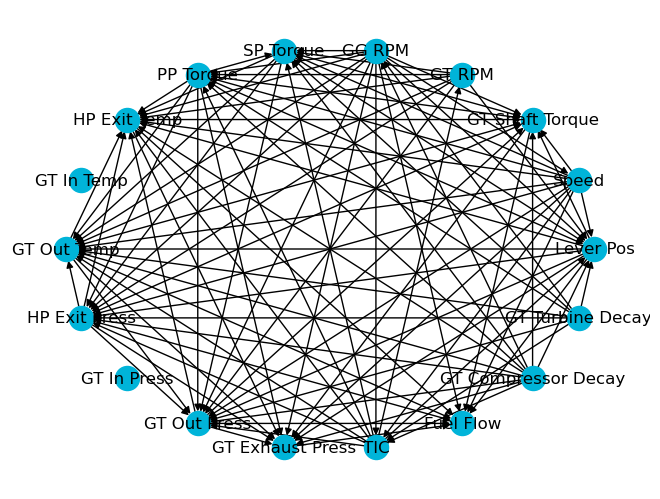

In [281]:
pos = nx.circular_layout(dag_Hill1)
nx.draw(dag_Hill1, node_color='#00b4d9', pos=pos, with_labels=True) 

In [267]:
warnings.filterwarnings('ignore')
est = HillClimbSearch(train_df)
dag_Hill2 = est.estimate(scoring_method="bdeuscore")
print("Num Nodes: %d; Num Edges: %d" % (len(dag_Hill2.nodes),len(dag_Hill2.edges)))

  0%|          | 0/1000000 [00:00<?, ?it/s]

Num Nodes: 18; Num Edges: 41


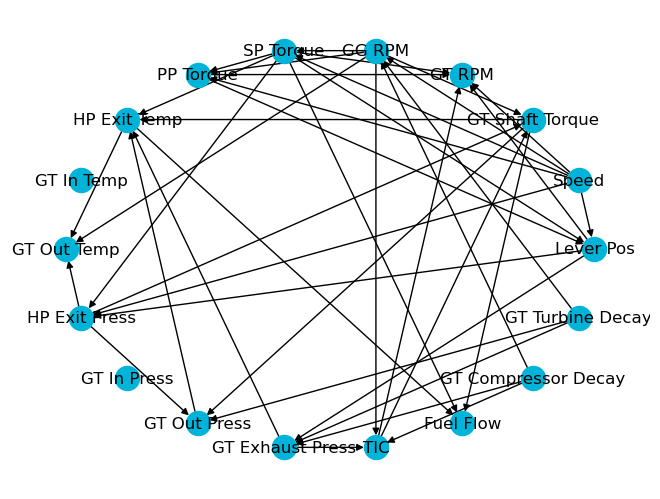

In [279]:
pos = nx.circular_layout(dag_Hill2)
nx.draw(dag_Hill2, node_color='#00b4d9', pos=pos, with_labels=True) 

In [325]:
warnings.filterwarnings('ignore')
est = HillClimbSearch(train_df)
dag_Hill3 = est.estimate(scoring_method="bicscore")
print("Num Nodes: %d; Num Edges: %d" % (len(dag_Hill3.nodes),len(dag_Hill3.edges)))

  0%|          | 0/1000000 [00:00<?, ?it/s]

Num Nodes: 18; Num Edges: 15


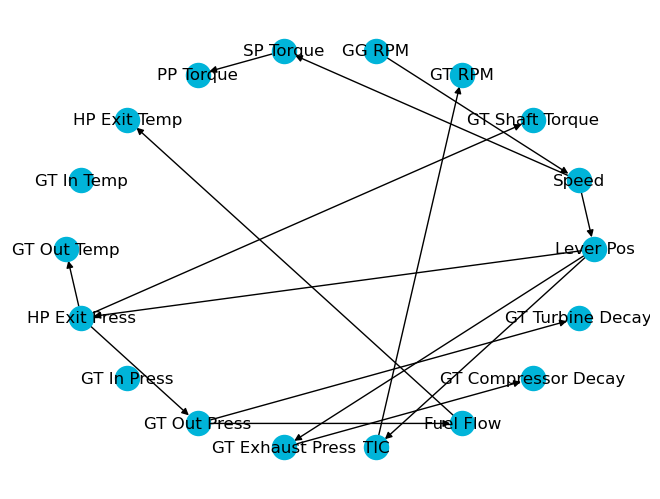

In [321]:
pos = nx.circular_layout(dag_Hill3)
nx.draw(dag_Hill3, node_color='#00b4d9', pos=pos, with_labels=True) 

In [238]:
est = TreeSearch(train_df)
dag_TreeSearch = est.estimate()
print("Num Nodes: %d; Num Edges: %d" % (len(dag_TreeSearch.nodes),len(dag_TreeSearch.edges)))

Building tree:   0%|          | 0/153.0 [00:00<?, ?it/s]

Num Nodes: 16; Num Edges: 15


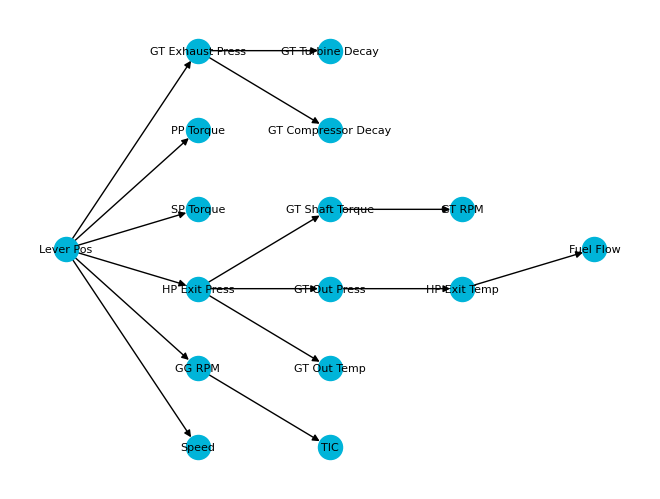

In [307]:
pos = nx.bfs_layout(dag_TreeSearch, start="Lever Pos")
nx.draw(dag_TreeSearch, node_color='#00b4d9', pos=pos, with_labels=True, font_size="8") 

##### Constraint Based is giving a value error and GES package no longer appears to be supported

In [252]:
c = PC(train_df)
c = c.build_skeleton()
pdag = c.orient_colliders(c)
dag_PC = c.apply_orientation_rules(pdag, return_type="dag")
print("Num Nodes: %d; Num Edges: %d" % (len(dag_PC.nodes),len(dag_PC.edges)))

  0%|          | 0/5 [00:00<?, ?it/s]

ValueError: The internally computed table of expected frequencies has a zero element at (0, 5).

#### Compare Edges Structures

The BIC score Hill Climb Search and the Tree Search are preferreddue to the limited number of edges. It is important and validiting in the BIC score network to see GT In Press and Temp to be disconnected, it was seen in the EDA that they had a constant value across all entries which would lead to not only clear independence from the other changing values, but also no gained information from including them in the network. This is further supported in the tree search network which does not even include the two nodes at all. Further, in the tree we see both Decay Variables are leaf nodes which is desirable for our planned inference. We will proceed with learning parameters for both of these two networks

#### Learn Parameters

In [383]:
dag_Hill3.remove_node("GT In Temp")
dag_Hill3.remove_node("GT In Press")
Hill_Fitted = BayesianNetwork(dag_Hill3)
Hill_Fitted.fit(train_df)
for cpd in Hill_Fitted.get_cpds():
    print(cpd)

+--------------------------------+-----+--------------+------------+
| Speed                          | ... | Speed(0.875) | Speed(1.0) |
+--------------------------------+-----+--------------+------------+
| Lever Pos(0.0)                 | ... | 0.0          | 0.0        |
+--------------------------------+-----+--------------+------------+
| Lever Pos(0.11639304092134281) | ... | 0.0          | 0.0        |
+--------------------------------+-----+--------------+------------+
| Lever Pos(0.24577309482969859) | ... | 0.0          | 0.0        |
+--------------------------------+-----+--------------+------------+
| Lever Pos(0.370374908110757)   | ... | 0.0          | 0.0        |
+--------------------------------+-----+--------------+------------+
| Lever Pos(0.4903209997549619)  | ... | 0.0          | 0.0        |
+--------------------------------+-----+--------------+------------+
| Lever Pos(0.6171281548640039)  | ... | 0.0          | 0.0        |
+--------------------------------+

In [367]:
Tree_Fitted = BayesianNetwork(dag_TreeSearch)
Tree_Fitted.fit(train_df)
for cpd in Tree_Fitted.get_cpds():
    print(cpd)

+--------------------------------+----------+
| Lever Pos(0.0)                 | 0.113296 |
+--------------------------------+----------+
| Lever Pos(0.11639304092134281) | 0.109721 |
+--------------------------------+----------+
| Lever Pos(0.24577309482969859) | 0.111955 |
+--------------------------------+----------+
| Lever Pos(0.370374908110757)   | 0.108939 |
+--------------------------------+----------+
| Lever Pos(0.4903209997549619)  | 0.111732 |
+--------------------------------+----------+
| Lever Pos(0.6171281548640039)  | 0.110503 |
+--------------------------------+----------+
| Lever Pos(0.7363391325655475)  | 0.113631 |
+--------------------------------+----------+
| Lever Pos(0.8659642244547904)  | 0.110168 |
+--------------------------------+----------+
| Lever Pos(0.9999999999999999)  | 0.110056 |
+--------------------------------+----------+
+--------------+----------------+-----+-------------------------------+
| Lever Pos    | Lever Pos(0.0) | ... | Lever Pos(0.99

## Model Validation

#### Accuracy of BP on testing data

In [427]:
bp_hill = BeliefPropagation(Hill_Fitted)
bp_tree = BeliefPropagation(Tree_Fitted)
results_hill = []
results_tree = []
evidence_vars = ["Lever Pos", "Speed", "GT Shaft Torque", "GT RPM", "GG RPM", "SP Torque", "PP Torque", 
           "HP Exit Temp", "GT Out Temp", "HP Exit Press", "GT Out Press",
           "GT Exhaust Press", "TIC", "Fuel Flow"]
query_vars = ["GT Compressor Decay", "GT Turbine Decay"]

for i, entry in test_df.iterrows():
    evidence1 = {col:entry[col] for col in evidence_vars}
    result_hill = bp_hill.map_query(variables=query_vars,
                             evidence=evidence1)
    result_tree = bp_tree.map_query(variables=query_vars,
                             evidence=evidence1)
    if entry[query_vars[0]] == result_hill[query_vars[0]] or entry[query_vars[1]] == result_hill[query_vars[1]]:
        results_hill.append(1)
    else:
        results_hill.append(0)
    if entry[query_vars[0]] == result_tree[query_vars[0]] or entry[query_vars[1]] == result_tree[query_vars[1]]:
        results_tree.append(1)
    else:
        results_tree.append(0)
print("MAP Query Accuracy (at least one decay state correctly predicted) for Hill Climb Structure: %.4f" % (sum(results_hill)/len(results_hill)))
print("MAP Query Accuracy (at least one decay state correctly predicted) for Tree Structure: %.4f" % (sum(results_tree)/len(results_tree)))

MAP Query Accuracy (at least one decay state correctly predicted) for Hill Climb Structure: 0.7922
MAP Query Accuracy (at least one decay state correctly predicted) for Tree Structure: 0.7865


#### Compare with "simple" neural net

In [423]:
x_train = pd.get_dummies(train_df.iloc[:, :-2].copy())
y_train = pd.get_dummies(train_df.iloc[:, -2:].copy())
x_test = pd.get_dummies(test_df.iloc[:, :-2].copy())
y_test = pd.get_dummies(test_df.iloc[:, -2:].copy())

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(96,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(6, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train,y_train, epochs=20, batch_size=16, validation_split=0.1)

# Evaluate on test set
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {accuracy:.2f}")

Epoch 1/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1492 - loss: 0.6220 - val_accuracy: 0.1106 - val_loss: 0.5937
Epoch 2/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1318 - loss: 0.5837 - val_accuracy: 0.1754 - val_loss: 0.5780
Epoch 3/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1755 - loss: 0.5720 - val_accuracy: 0.1397 - val_loss: 0.5697
Epoch 4/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1530 - loss: 0.5604 - val_accuracy: 0.1453 - val_loss: 0.5629
Epoch 5/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1505 - loss: 0.5578 - val_accuracy: 0.1508 - val_loss: 0.5601
Epoch 6/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1441 - loss: 0.5579 - val_accuracy: 0.1408 - val_loss: 0.5573
Epoch 7/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1474 - loss: 0.5516 - val_accuracy: 0.1922 - val_loss: 0.5558
Epoch 8/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1584 - loss: 0.5529 - val_accuracy: 0.

Note that I believe the above test accuracy would be predicting both decay states correctly not just a one or the other. When I ran the MAP query to give an accuracy regarding both decays being correct it had an accuracy of around 30%. The structure we have thereby outperforms the simple not well tuned neural net.

## Inference Tasks - Warning Table Generation

#### Select Most Relevant Variables

With similar performance between Hill and Tree, we will use the tree as it is the easier to interpret and faster to compute. With this we want to pick a small contigent of variables that will be measured on a round. Based on the tree structure we will select HP Exit Press, GT Exhaust Press, and Lever Pos as our three evidence variables that will inform the decision.

#### Define Evidence / Table Structure

In [488]:
Lever_Positions = [0.0, 0.11639304092134281, 0.24577309482969859, 0.370374908110757, 0.4903209997549619, 0.6171281548640039, 0.7363391325655475, 0.8659642244547904, 0.9999999999999999]
HP_Exit_Pressures = ["1","2","3","4","5","6","7","8","9"]
GT_Exhaust_Pressures = [0.0, 0.030303030303034717, 0.060606060606058776, 0.09090909090909349, 0.1212121212121211, 0.2121212121212146, 0.2424242424242422, 0.3333333333333357, 0.3636363636363633, 0.4848484848484844, 0.5151515151515156, 0.6363636363636367, 0.6666666666666643, 0.696969696969699, 0.7272727272727231, 0.9090909090909065, 0.9393939393939377, 0.9696969696969653, 1.0]

In [490]:
result_table = [[{"Lever Pos":l,"HP Exit Press":h,"GT Exhaust Press":g},[]] for l in Lever_Positions for h in HP_Exit_Pressures for g in GT_Exhaust_Pressures]

In [492]:
len(result_table)

1539

#### Perform Inference - Store Results in Table Structure

In [494]:
for entry in result_table:
    result_tree = bp_tree.map_query(variables=query_vars,
                             evidence=entry[0])
    entry[1].append(result_tree[query_vars[0]]) 
    entry[1].append(result_tree[query_vars[1]])
print(result_table)

[[{'Lever Pos': 0.0, 'HP Exit Press': '1', 'GT Exhaust Press': 0.0}, ['Normal', 'Normal']], [{'Lever Pos': 0.0, 'HP Exit Press': '1', 'GT Exhaust Press': 0.030303030303034717}, ['High', 'High']], [{'Lever Pos': 0.0, 'HP Exit Press': '1', 'GT Exhaust Press': 0.060606060606058776}, ['High', 'High']], [{'Lever Pos': 0.0, 'HP Exit Press': '1', 'GT Exhaust Press': 0.09090909090909349}, ['High', 'High']], [{'Lever Pos': 0.0, 'HP Exit Press': '1', 'GT Exhaust Press': 0.1212121212121211}, ['High', 'High']], [{'Lever Pos': 0.0, 'HP Exit Press': '1', 'GT Exhaust Press': 0.2121212121212146}, ['High', 'High']], [{'Lever Pos': 0.0, 'HP Exit Press': '1', 'GT Exhaust Press': 0.2424242424242422}, ['High', 'High']], [{'Lever Pos': 0.0, 'HP Exit Press': '1', 'GT Exhaust Press': 0.3333333333333357}, ['High', 'High']], [{'Lever Pos': 0.0, 'HP Exit Press': '1', 'GT Exhaust Press': 0.3636363636363633}, ['High', 'High']], [{'Lever Pos': 0.0, 'HP Exit Press': '1', 'GT Exhaust Press': 0.4848484848484844}, ['Hi

In [498]:
for entry in result_table:
    if entry[1][0] == "Low" or entry[1][1] == "Low":
        print(entry)

[{'Lever Pos': 0.370374908110757, 'HP Exit Press': '4', 'GT Exhaust Press': 0.09090909090909349}, ['Low', 'Normal']]
[{'Lever Pos': 0.7363391325655475, 'HP Exit Press': '7', 'GT Exhaust Press': 0.4848484848484844}, ['Low', 'Normal']]
[{'Lever Pos': 0.8659642244547904, 'HP Exit Press': '8', 'GT Exhaust Press': 0.6363636363636367}, ['Low', 'Low']]
[{'Lever Pos': 0.8659642244547904, 'HP Exit Press': '8', 'GT Exhaust Press': 0.6666666666666643}, ['Low', 'Normal']]
[{'Lever Pos': 0.9999999999999999, 'HP Exit Press': '9', 'GT Exhaust Press': 0.9090909090909065}, ['Low', 'Normal']]


Translate the above back into meaningful values by unscaling / discretizing

HP Exit - translate grouping value into normalized range, reverse min-max scaling. Ranges: [-0.1,0.025,0.075,0.125,0.25,0.35,0.5,0.625,0.85,1.1]; scaling: (1.093, 4.560)

GT Exhaust Pressure - reverse min-max scaling, (1.019, 1.052)

Lever Position - reverse min-max scaling, (1.138,9.3)

In [10]:
critical = [{'Lever Pos': 0.370374908110757, 'HP Exit Press': '4', 'GT Exhaust Press': 0.09090909090909349}, 
{'Lever Pos': 0.7363391325655475, 'HP Exit Press': '7', 'GT Exhaust Press': 0.4848484848484844}, 
{'Lever Pos': 0.8659642244547904, 'HP Exit Press': '8', 'GT Exhaust Press': 0.6363636363636367}, 
{'Lever Pos': 0.8659642244547904, 'HP Exit Press': '8', 'GT Exhaust Press': 0.6666666666666643}, 
{'Lever Pos': 0.9999999999999999, 'HP Exit Press': '9', 'GT Exhaust Press': 0.9090909090909065}]
HP_zones = [-0.1,0.025,0.075,0.125,0.25,0.35,0.5,0.625,0.85,1.1]
for zone in critical:
    for var in zone.keys():
        if var == "Lever Pos":
            print("%s: %.3f" %(var, zone[var]*(9.3-1.138) + 1.138))
        elif var == "GT Exhaust Press":
            print("%s: %.3f" %(var, zone[var]*(1.052-1.019) + 1.019))
        elif var == "HP Exit Press":
            bottom = HP_zones[int(zone[var])-1]
            top = HP_zones[int(zone[var])]
            print("%s: (%.3f, %.3f)" %(var, bottom*(4.56-1.093)+1.093, top*(4.56-1.093)+1.093))
    print()

Lever Pos: 4.161
HP Exit Press: (1.526, 1.960)
GT Exhaust Press: 1.022

Lever Pos: 7.148
HP Exit Press: (2.826, 3.260)
GT Exhaust Press: 1.035

Lever Pos: 8.206
HP Exit Press: (3.260, 4.040)
GT Exhaust Press: 1.040

Lever Pos: 8.206
HP Exit Press: (3.260, 4.040)
GT Exhaust Press: 1.041

Lever Pos: 9.300
HP Exit Press: (4.040, 4.907)
GT Exhaust Press: 1.049

